# Combining Solar Panels

This study explores the effect of variability in exposure and panel characteristics of PV panels in an array on the array's yield.




### Setup

Import neccessary packages.  Setup constants and panel parameters.

In [144]:
from pvlib import pvsystem, singlediode, ivtools
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.constants import e as qe, k as kB

# For simplicity, use cell temperature of 25C for all calculations.
# kB is J/K, qe is C=J/V
# kB * T / qe -> V
Vth = kB * (273.15+25) / qe

# Input the module parameters from the datasheet
# Panasonic N330
module_parameters = {
    'celltype': 'monoSi',
    'V_mp_ref': 58.0,
    'I_mp_ref': 5.7,
    'V_oc_ref': 69.7,
    'I_sc_ref': 6.07,
    'alpha_sc': 0.00334,
    'beta_oc': -0.16,
    'gamma_pmp': -0.258,
    'cells_in_series': 96,  # data sheet shows 96 cells and states 4 bypass diodes
    'temp_ref': 25,
    'breakdown_factor': 2e-3, #borrowed from pvlib example
    'breakdown_exp': 3, #borrowed from pvlib example
    'breakdown_voltage': -15, #borrowed from pvlib example
    'num_diodes': 4, #borrowed from pvlib example
}

# convert the module parameters to cell parameters
cell_parameters = {
    'celltype': 'monoSi',
    'V_mp_ref': module_parameters['V_mp_ref'] / module_parameters['cells_in_series'],
    'I_mp_ref': module_parameters['I_mp_ref'], #would not change
    'V_oc_ref': module_parameters['V_oc_ref'] / module_parameters['cells_in_series'],
    'I_sc_ref': module_parameters['I_sc_ref'],
    'alpha_sc': 0.00334,
    'beta_oc': module_parameters['beta_oc'] / module_parameters['cells_in_series'],
    'gamma_pmp': -0.258,
    'temp_ref': 25,
    'breakdown_factor': 2e-3, #borrowed from pvlib example
    'breakdown_exp': 3, #borrowed from pvlib example
    'breakdown_voltage': -15, #borrowed from pvlib example
}

#looking into how to treat series and shunt resistance going from module to cell

# Use ivtools to estimate parameters for the CEC SDM
I_L_ref, I_o_ref, R_s, R_sh_ref, a_ref, Adjust = ivtools.sdm.fit_cec_sam(module_parameters['celltype'], 
                                                                         module_parameters['V_mp_ref'], 
                                                                         module_parameters['I_mp_ref'], 
                                                                         module_parameters['V_oc_ref'], 
                                                                         module_parameters['I_sc_ref'], 
                                                                         module_parameters['alpha_sc'], 
                                                                         module_parameters['beta_oc'], 
                                                                         module_parameters['gamma_pmp'], 
                                                                         module_parameters['cells_in_series'], 
                                                                         module_parameters['temp_ref'])

# Add these new estimated parameters
module_parameters['I_L_ref']=I_L_ref
module_parameters['I_o_ref']=I_o_ref
module_parameters['R_s']=R_s
module_parameters['R_sh_ref']=R_sh_ref
module_parameters['a_ref']=a_ref

print('Rsh_module=',module_parameters['R_sh_ref'])
print('Rs_module=',module_parameters['R_s'])

# add these new estimated parameters to the cell parameters
cell_parameters['I_L_ref']=I_L_ref
cell_parameters['I_o_ref']=I_o_ref
cell_parameters['R_s']=R_s/module_parameters['cells_in_series']
cell_parameters['R_sh_ref']=R_sh_ref/module_parameters['cells_in_series']
cell_parameters['a_ref']=a_ref/module_parameters['cells_in_series']

print('Rsh_cell=',cell_parameters['R_sh_ref'])
print('Rs_cell=',cell_parameters['R_s'])

# Full sun
Geff_full=1000

# Shaded
Geff_shade=100


Rsh_module= 457.49579164575226
Rs_module= 0.7372538415650246
Rsh_cell= 4.765581162976586
Rs_cell= 0.007679727516302339


Use De Soto simulate an IV curve.

In [145]:

def simulate_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto to simulate a full IV curve.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    IL, I0, Rs, Rsh, nNsVth = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )

    SDE_params = {
        'photocurrent': IL,
        'saturation_current': I0,
        'resistance_series': Rs,
        'resistance_shunt': Rsh,
        'nNsVth': nNsVth
    }

    # Use the SDE parameters to calculate points on the IV curve
    
    curve_info = pvsystem.singlediode(method='lambertw', **SDE_params)
    v_curve = pd.DataFrame({'v': np.linspace(0, curve_info['v_oc'], 100)})
    i_curve = pd.DataFrame({'i': pvsystem.i_from_v(voltage=v_curve['v'], method='lambertw', **SDE_params)})

    return pd.DataFrame({
    'i': i_curve['i'],
    'v': v_curve['v'],
    })

def simulate_cell_full_curve(parameters, Geff, Tcell, ivcurve_pnts=1000):
    """
    Use De Soto and Bishop to simulate a full IV curve with both
    forward and reverse bias regions.
    """
    # adjust the reference parameters according to the operating
    # conditions using the De Soto model:
    sde_args = pvsystem.calcparams_desoto(
        Geff,
        Tcell,
        alpha_sc=parameters['alpha_sc'],
        a_ref=parameters['a_ref'],
        I_L_ref=parameters['I_L_ref'],
        I_o_ref=parameters['I_o_ref'],
        R_sh_ref=parameters['R_sh_ref'],
        R_s=parameters['R_s'],
    )
    # sde_args has values:
    # (photocurrent, saturation_current, resistance_series,
    # resistance_shunt, nNsVth)

    # Use Bishop's method to calculate points on the IV curve with V ranging
    # from the reverse breakdown voltage to open circuit
    kwargs = {
        'breakdown_factor': parameters['breakdown_factor'],
        'breakdown_exp': parameters['breakdown_exp'],
        'breakdown_voltage': parameters['breakdown_voltage'],
    }
    v_oc = singlediode.bishop88_v_from_i(
        0.0, *sde_args, **kwargs
    )
    # ideally would use some intelligent log-spacing to concentrate points
    # around the forward- and reverse-bias knees, but this is good enough:
    vd = np.linspace(0.99*kwargs['breakdown_voltage'], v_oc, ivcurve_pnts)

    ivcurve_i, ivcurve_v, _ = singlediode.bishop88(vd, *sde_args, **kwargs)
    return pd.DataFrame({
        'i': ivcurve_i,
        'v': ivcurve_v,
    })

def interpolate(df, i):
    """convenience wrapper around scipy.interpolate.interp1d"""
    f_interp = interp1d(np.flipud(df['i']), np.flipud(df['v']), kind='linear',
                        fill_value='extrapolate')
    return f_interp(i)


def combine_series(dfs):
    """
    Combine IV curves in series by aligning currents and summing voltages.
    The current range is based on the first curve's current range.
    """
    df1 = dfs[0]
    imin = df1['i'].min()
    imax = df1['i'].max()
    i = np.linspace(imin, imax, 1000)
    v = 0
    for df2 in dfs:
        v_cell = interpolate(df2, i)
        v += v_cell
    return pd.DataFrame({'i': i, 'v': v})

def simulate_module(cell_parameters, poa_direct, poa_diffuse, Tcell,
                    shaded_fraction, shade_orientation, cells_per_string, num_strings):
    """
    Simulate the IV curve for a partially shaded module.
    If shade_orientation = 'portrait',  is assumed to be coming up from the bottom of the module when in
    portrait orientation, so it affects all substrings equally.
    If shade_orientation = 'landscape',  is assumed to be coming from the bottom of the module when in
    landscape orientation, so it affects substrings differently.
    For simplicity, cell temperature is assumed to be uniform across the
    module, regardless of variation in cell-level illumination.
    Substrings are assumed to be "down and back", so the number of cells per
    string is divided between two columns of cells.
    """

    # portrait
    if shade_orientation == 'portrait':
        # find the number of cells per column that are in full shadow
        nrow = cells_per_string // 2
        nrow_full_shade = int(shaded_fraction * nrow)
        # find the fraction of shade in the border row
        partial_shade_fraction = 1 - (shaded_fraction * nrow - nrow_full_shade)

        df_lit = simulate_full_curve(
            cell_parameters,
            poa_diffuse + poa_direct,
            Tcell)
        df_partial = simulate_full_curve(
            cell_parameters,
            poa_diffuse + partial_shade_fraction * poa_direct,
            Tcell)
        df_shaded = simulate_full_curve(
            cell_parameters,
            poa_diffuse,
            Tcell)
        # build a list of IV curves for a single column of cells (half a substring)
        include_partial_cell = (shaded_fraction < 1)
        half_substring_curves = (
            [df_lit] * (nrow - nrow_full_shade - 1)
            + ([df_partial] if include_partial_cell else [])  # noqa: W503
            + [df_shaded] * nrow_full_shade  # noqa: W503
        )
        substring_curve = combine_series(half_substring_curves)
        substring_curve['v'] *= 2  # turn half strings into whole strings
        # bypass diode:
        substring_curve['v'] = substring_curve['v'].clip(lower=-0.5)
        # no need to interpolate since we're just scaling voltage directly:
        substring_curve['v'] *= num_strings
        return substring_curve
    if shade_orientation == 'landscape':
        ncolumn = num_strings * 2
        ncolumn_full_shade = int(shaded_fraction * ncolumn)
        ncolumn_lit = ncolumn - ncolumn_full_shade

        # find the fraction of shade in the border column
        partial_shade_fraction = 1 - (shaded_fraction * ncolumn - ncolumn_full_shade)
        # build a list of IV curves for a single string of cells
        n_strings_shaded = ncolumn_full_shade // 2
        n_strings_lit = ncolumn_lit // 2
        n_strings_partial = num_strings - n_strings_shaded - n_strings_lit
        # need to determine if partial string is mostly lit or mostly shade
        if ncolumn_full_shade % 2 == 0:
            mostly_lit = True
        else:
            mostly_lit = False
            
        df_lit = simulate_full_curve(
            cell_parameters,
            poa_diffuse + poa_direct,
            Tcell)
        df_partial = simulate_full_curve(
            cell_parameters,
            poa_diffuse + partial_shade_fraction * poa_direct,
            Tcell)
        df_shaded = simulate_full_curve(
            cell_parameters,
            poa_diffuse,
            Tcell)
        
        cells_per_column = cells_per_string // 2
        #build a list of IV curves for a string of cells
        lit_string = ([df_lit] * cells_per_string)
        shaded_string = ([df_shaded] * cells_per_string)
        if n_strings_partial > 0:
            if mostly_lit:
                partial_string = ([df_partial] * cells_per_column
                                         + [df_lit] * cells_per_column)
            else:
                partial_string = ([df_partial] * cells_per_column 
                                         + [df_shaded] * cells_per_column)
        else:
            partial_string = []
        
        #print('lit_string=',lit_string)
        print('shaded_string=',shaded_string)
        #print('partial_string=',partial_string)

        lit_string_curve = combine_series(lit_string)
        shaded_string_curve = combine_series(shaded_string)
        if n_strings_partial > 0:
            partial_string_curve = combine_series(partial_string)
        # bypass diode:
        shaded_string_curve['v'] = shaded_string_curve['v'].clip(lower=-0.5)
        if n_strings_partial > 0:
            partial_string_curve['v'] = partial_string_curve['v'].clip(lower=-0.5)

        # add up the voltages
        lit_string_curve['v'] = lit_string_curve['v'] * n_strings_lit + shaded_string_curve['v'] * n_strings_shaded + shaded_string_curve['v'] * n_strings_shaded 
        if n_strings_partial > 0:
            lit_string_curve['v'] = lit_string_curve['v'] + partial_string_curve['v'] * n_strings_partial

        return lit_string_curve
    


shaded_string= [               i         v
0   6.078802e-01  0.000000
1   6.077383e-01  0.006765
2   6.075964e-01  0.013530
3   6.074544e-01  0.020295
4   6.073125e-01  0.027060
..           ...       ...
95  3.733938e-01  0.642673
96  3.087428e-01  0.649438
97  2.272106e-01  0.656203
98  1.254585e-01  0.662968
99  9.769963e-15  0.669733

[100 rows x 2 columns],                i         v
0   6.078802e-01  0.000000
1   6.077383e-01  0.006765
2   6.075964e-01  0.013530
3   6.074544e-01  0.020295
4   6.073125e-01  0.027060
..           ...       ...
95  3.733938e-01  0.642673
96  3.087428e-01  0.649438
97  2.272106e-01  0.656203
98  1.254585e-01  0.662968
99  9.769963e-15  0.669733

[100 rows x 2 columns],                i         v
0   6.078802e-01  0.000000
1   6.077383e-01  0.006765
2   6.075964e-01  0.013530
3   6.074544e-01  0.020295
4   6.073125e-01  0.027060
..           ...       ...
95  3.733938e-01  0.642673
96  3.087428e-01  0.649438
97  2.272106e-01  0.656203
98  1.254585e-01

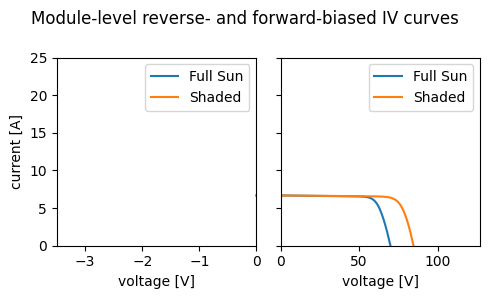

In [146]:
kwargs = {
    'cell_parameters': cell_parameters,
    'poa_direct': Geff_full,
    'poa_diffuse': Geff_shade,
    'Tcell': 25,
    'shade_orientation': 'landscape',
    'cells_per_string': 24,
    'num_strings': 4,
}

def plot_curves(dfs, labels, title):
    """plot the forward- and reverse-bias portions of an IV curve"""
    fig, axes = plt.subplots(1, 2, sharey=True, figsize=(5, 3))
    for df, label in zip(dfs, labels):
        df.plot('v', 'i', label=label, ax=axes[0])
        df.plot('v', 'i', label=label, ax=axes[1])
        axes[0].set_xlim(right=0)
        axes[0].set_ylim([0, 25])
        axes[1].set_xlim([0, df['v'].max()*1.5])
    axes[0].set_ylabel('current [A]')
    axes[0].set_xlabel('voltage [V]')
    axes[1].set_xlabel('voltage [V]')
    fig.suptitle(title)
    fig.tight_layout()
    return axes

module_curve_full_sun = simulate_module(shaded_fraction=0, **kwargs)
module_curve_shaded = simulate_module(shaded_fraction=0.25, **kwargs)
ax = plot_curves([module_curve_full_sun, module_curve_shaded],
                 labels=['Full Sun', 'Shaded'],
                 title='Module-level reverse- and forward-biased IV curves')

(0.0, 25.0)

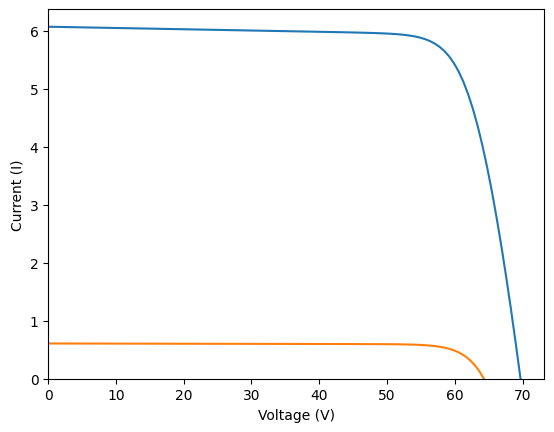

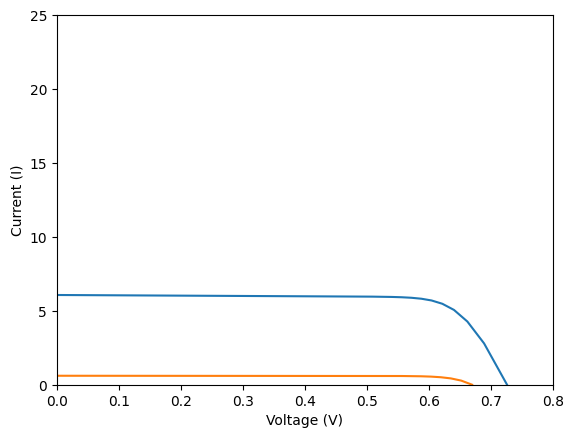

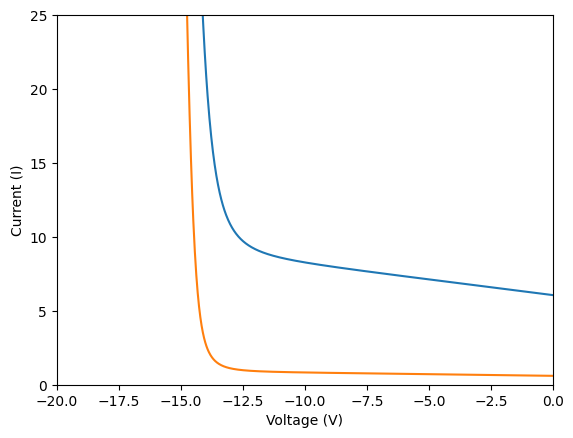

In [147]:


# create a curve and plot (test)
curve_full = simulate_full_curve(module_parameters, Geff_full, 25)
curve_shade = simulate_full_curve(module_parameters, Geff_shade, 25)
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=0)  # Set the left limit of the x-axis to 0
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0

# create a curve and plot for cells (test)

curve_full = simulate_cell_full_curve(cell_parameters, Geff_full, 25)
curve_shade = simulate_cell_full_curve(cell_parameters, Geff_shade, 25)
plt.figure()
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=0)  # Set the left limit of the x-axis to 0
plt.xlim(right=0.8)  # Set the right limit of the x-axis to 0.7
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0
plt.ylim(top=25)  # Set the top limit of the y-axis to 0.1

plt.figure()
plt.plot(curve_full['v'], curve_full['i'])
plt.plot(curve_shade['v'], curve_shade['i'])
plt.xlabel('Voltage (V)')
plt.ylabel('Current (I)')
plt.xlim(left=-20)  # Set the left limit of the x-axis to 0
plt.xlim(right=0)  # Set the right limit of the x-axis to 0.7
plt.ylim(bottom=0)  # Set the bottom limit of the y-axis to 0
plt.ylim(top=25)  # Set the top limit of the y-axis to 0.1
#plt.savefig('test.png')


## Uniform Case (Control)
### 2S2P
### 4P


## Uniform Case (Control)
### Series
### Parallel
### Dedicated MPPT

## Variation In Exposure Angle
### Series
### Parallel
### Dedicated MPPT

## Variation in Shading
### Series
### Parallel
### Dedicated MPPT

## Variation in Panel Make/Model
### Series
### Parallel
### Dedicated MPPT